In [2]:
import sys
sys.path.insert(0, "../kitti/")
from util_kitti import kitti_label_file_parser, kitti_calib_file_parser, get_corner_2D
from util_kitti import AVG_HEIGT, AVG_WIDTH, AVG_LENTH
from util_kitti import ANCHOR_Y_3D_MEAN, ANCHOR_Y_3D_STD, KITTI_Object, draw_2Dbox
from util_kitti import draw_corner_2D, draw_birdeyes, set_bev_background, init_img_plt, load_tf_image

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.path import Path
import matplotlib.patches as patches

import torch
import pickle
import numpy as np 
from math import pi, atan2
import random 
import copy
import cv2
import pprint

ANCHOR_NAME = 'anchor_single_pixel'
INPUT_SHAPE = (288, 1280)

# Anchor Generation

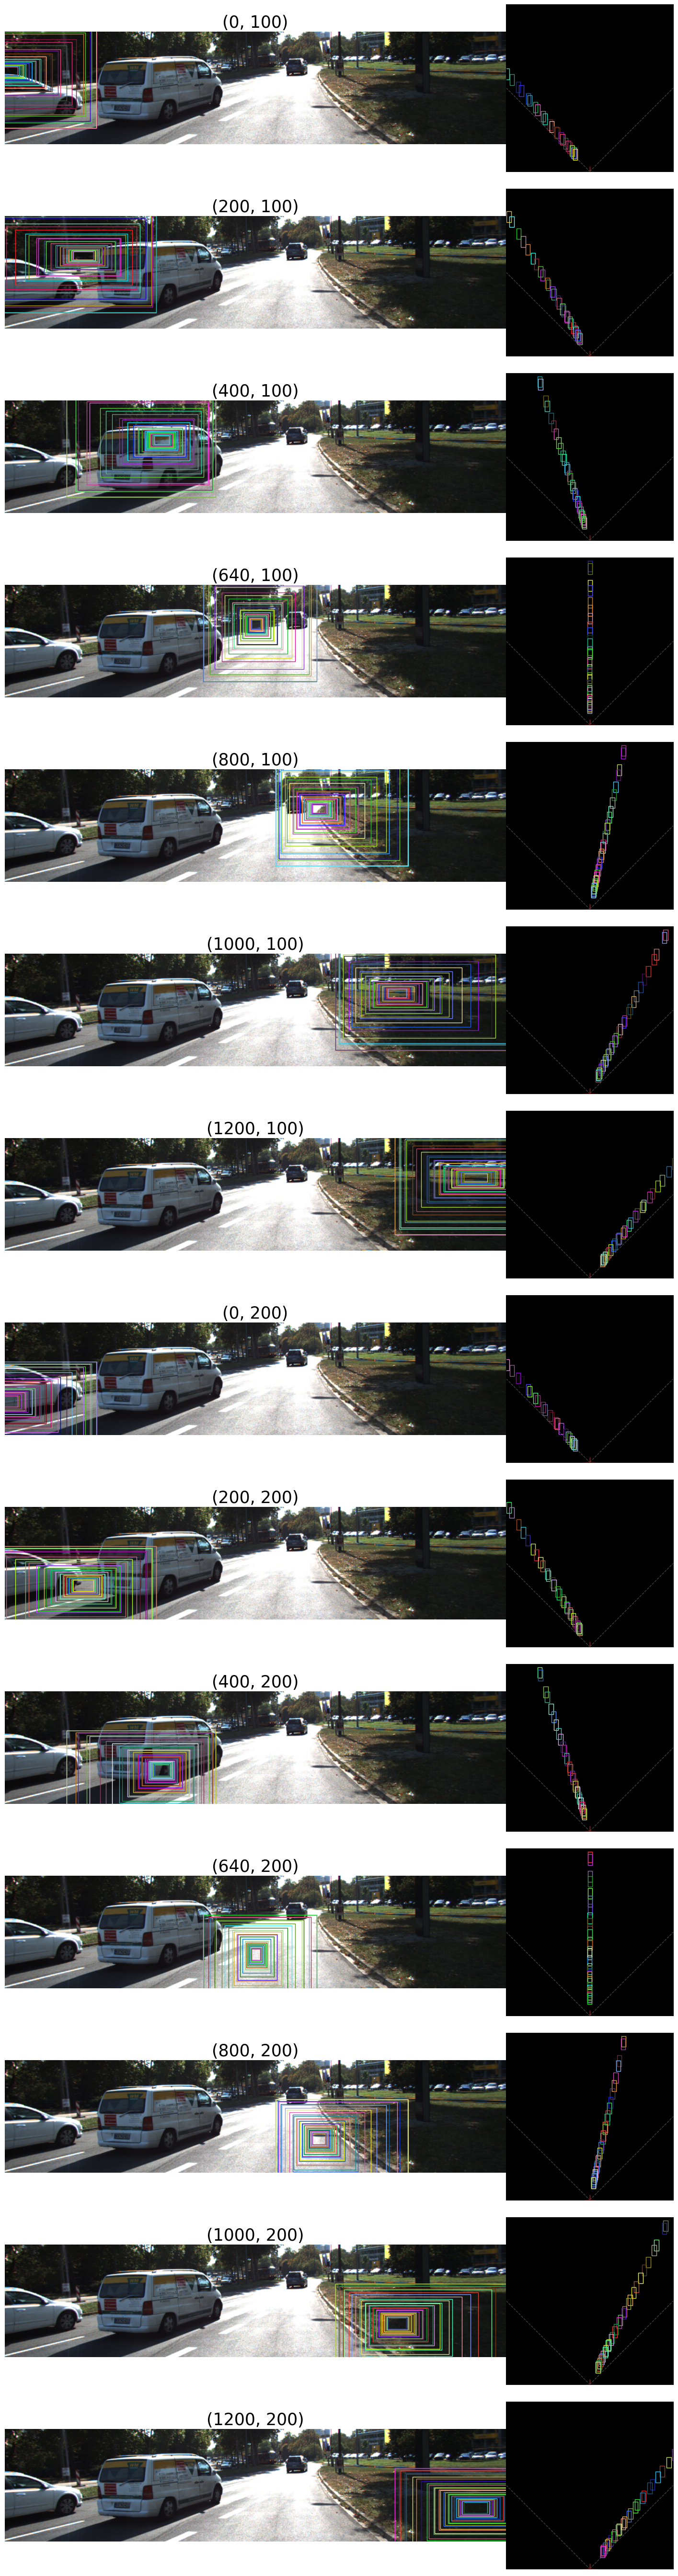

In [3]:
# %%script false --no-raise-error
'''
This script generate single pixelwise anchor for GAC network, it output "mean.npy", "std.npy", and "bb2d.npy" for GAC to use 
Note 
'''
# anchors_tensor.append([a.xmin, a.ymin, a.xmax, a.ymax, 0,
#                         a.cx, a.cy, a.cz, a.w, a.h, a.l, a.alpha,
#                         a.x3d, a.y3d, a.z3d, a.rot_y])
P2  = kitti_calib_file_parser("/home/lab530/KenYu/kitti/training/calib/000169.txt",
                              new_shape_tf = INPUT_SHAPE,
                              crop_tf = 100)
img = load_tf_image("/home/lab530/KenYu/kitti/training/image_2/000296.png") # 'A' type image

cx_cys = [(0, 100), (200, 100), (400, 100), (640, 100), (800, 100), (1000, 100), (1200, 100),
          (0, 200), (200, 200), (400, 200), (640, 200), (800, 200), (1000, 200), (1200, 200)]

# These setting is from GAC statistic result
cz_list = [56.98797991, 56.04226394,
           50.06823853, 48.19439468,
            43.91934331, 41.0492084 ,
            38.2276806 , 35.05968873,
            32.96152537, 30.32252282,
            29.04565675, 26.16832821,
            25.48751161, 23.05543279,
            22.13760396, 19.7498472 ,
            18.93810035, 16.81772621,
            16.1171727 , 14.24002636,
            13.79638931, 12.15158061,
            11.54314274, 10.13608401,
            9.17043185,  8.49685988,
            7.56959524,  7.34287524,
            6.78601669,  6.64104037,
            6.18923748,  6.20296784]

cz_std = [9.09031785, 9.38618033,
            9.54007986, 9.35654368,
            9.15279699, 8.71501209,
            8.52045028, 7.82572055,
            7.53118419, 6.79434155,
            6.53105367, 5.39632468,
            5.59955139, 4.47863999,
            5.01825271, 4.10331455,
            4.28522112, 3.62006981,
            3.52623707, 3.20755861,
            2.99044567, 3.03025413,
            2.94830599, 2.89681568,
            2.85578119, 2.50499439,
            2.30600518, 2.09231131,
            1.88066461, 1.74533658,
            1.566734  , 1.50293911]

bbox_2d = []

# Input: cx, cy, P2
# Output: z rot_y w, h, l, 2DBBOX
axs = init_img_plt([img]*len(cx_cys), titles = [f"({cx}, {cy})" for cx, cy in cx_cys])


# Draw Anchor on image
anchors_tensor = []
# print(f"(cx, cy) = {(cx, cy)}")
for i, cx_cy in enumerate(cx_cys):
    for cz in cz_list:
        cx, cy = cx_cy
        # Convert cx,cy,cz to x3d,y3d,z3d
        loc_3d = np.linalg.inv(P2[:, :3]) @ np.array([[cx*cz], [cy*cz], [cz]])
        loc_3d[1, 0] += AVG_HEIGT / 2.0 
        
        rot_y = pi/2
        str_line = f"Car NA NA NA NA NA NA NA {AVG_HEIGT} {AVG_WIDTH} {AVG_LENTH} {loc_3d[0, 0]} {loc_3d[1, 0]} {loc_3d[2, 0]} {rot_y} NA"
        # a = KITTI_Object(str_line, is_transform = False, center_2d = (cx,cy,cz)) # TODO center_2d is problemetic
        a = KITTI_Object(str_line, tf_matrix = P2)

        # 
        if cx_cy == (640, 100):
            w_2d = a.xmax - a.xmin
            h_2d = a.ymax - a.ymin
            bbox_2d.append([-w_2d/2, -h_2d/2, w_2d/2, h_2d/2])

        # Draw anchor
        rnd_color = (random.random(), random.random(), random.random())
        # draw_corner_2D(axs[i][0], a.corner_2D, color = rnd_color, is_draw_front = False)
        draw_2Dbox    (axs[i][0], (a.xmin, a.ymin, a.xmax, a.ymax), color = rnd_color)
        draw_birdeyes (axs[i][1], a, color = rnd_color)
        

# Output Single Pixel Anchor

In [4]:
%%script false --no-raise-error
# [cz, sin(alpha*2), cos(alpha*2), w, h , l]
alpha = 0
from math import sin, cos

# Get cz_std
# Reference from npy file 

# The w, h, l is from anchor_gac_original npy file
mean = np.array([[    cz, sin(2*alpha), cos(2*alpha), 1.62247087, 1.53504054, 3.90582067] for cz   in cz_list])
std  = np.array([[  cz_s,          0.5,          0.5, 0.10394107, 0.14244205, 0.44820999] for cz_s in cz_std])
# print(mean[0])
# print(std[0])
# print(bbox_2d)

np.save("gac_original_npy/mean.npy", mean)
np.save("gac_original_npy/std.npy", std)
np.save("gac_original_npy/2dbbox.npy", bbox_2d)


# Output Pyrimid Anchor

In [5]:
%%script false --no-raise-error
'''
This output the pixelwise anchor for pyrimid feature map,
Assuming we have 5 level of features and every pixel has 8 anchors
'''

# [cz, sin(alpha*2), cos(alpha*2), w, h , l]
from math import sin, cos
# Get cz_std
mean_dict = {}
std_dict = {}
bbox_2d_dict = {}

# Reference from npy file 
alpha = 0
for i, level in enumerate([3,4,5,6,7]):
    # print(cz_list[i*6: i*6 + 8])
    mean_dict[level] = np.array([[    cz, sin(2*alpha), cos(2*alpha), 1.62247087, 1.53504054, 3.90582067] for cz   in cz_list[i*6: i*6 + 8] ])
    std_dict[level]  = np.array([[  cz_s,          0.5,          0.5, 0.10394107, 0.14244205, 0.44820999] for cz_s in cz_std[i*6: i*6 + 8]])
    bbox_2d_dict[level]  = np.array([ bbox for bbox in bbox_2d[i*6: i*6 + 8]])

# print(mean_dict)
import pickle
with open("gac_original_pyrimid_npy/mean.pkl", 'wb') as f:
    pickle.dump(mean_dict,f)
with open("gac_original_pyrimid_npy/std.pkl", 'wb') as f:
    pickle.dump(std_dict,f)
with open("gac_original_pyrimid_npy/2dbbox.pkl", 'wb') as f:
    pickle.dump(bbox_2d_dict,f)


# Output ALL anchors

In [6]:
%%script false --no-raise-error
ANCHOR_NAME = "anchor_center3D"
# %%script false --no-raise-error
# anchors_tensor.append([a.xmin, a.ymin, a.xmax, a.ymax, 0, 
#                         a.cx, a.cy, a.cz, a.w, a.h, a.l, a.alpha,
#                         a.x3d, a.y3d, a.z3d, a.rot_y])

anchors_tensor = []
for y_f_idx in range(18):
    for x_f_idx in range(80):
        cx = x_f_idx * 16 + 8
        cy = y_f_idx * 16 + 8
        for i_cz, cz in enumerate(cz_list):
            # Convert cx,cy,cz to x3d,y3d,z3d
            loc_3d = np.linalg.inv(P2[:, :3]) @ np.array([[cx*cz], [cy*cz], [cz]])
            loc_3d[1, 0] += AVG_HEIGT / 2.0 
            
            # Filter unreasonable y_3d 
            # if not (func(cz, *popt_lower) < loc_3d[1, 0] < func(cz, *popt_upper)): continue

            rot_y = pi/2
            str_line = f"Car NA NA NA NA NA NA NA {AVG_HEIGT} {AVG_WIDTH} {AVG_LENTH} {loc_3d[0, 0]} {loc_3d[1, 0]} {loc_3d[2, 0]} {rot_y} NA"
            # a = KITTI_Object(str_line, is_transform = False, center_2d = (cx,cy,cz)) # TODO center_2d is problemetic
            a = KITTI_Object(str_line, tf_matrix = P2)
            
            # # Inject 2D bounding box
            # a.xmin = bbox_2d[i_cz][0] + cx
            # a.ymin = bbox_2d[i_cz][1] + cy
            # a.xmax = bbox_2d[i_cz][2] + cx
            # a.ymax = bbox_2d[i_cz][3] + cy
            
            # cz_list
            anchors_tensor.append(np.array([a.xmin, a.ymin, a.xmax, a.ymax, 0, a.cx, a.cy, a.cz, a.w, a.h, a.l, a.alpha, a.x3d, a.y3d, a.z3d, a.rot_y]))

anchors_tensor = np.array(anchors_tensor)
anchors_tensor = torch.FloatTensor(anchors_tensor)
print(f"anchors_tensor.shape = {anchors_tensor.shape}") # [14284, 12]

#####################
### Output Anchor ###
#####################

# 3D Anchor
with open(f"/home/lab530/KenYu/ml_toolkit/anchor_generation/pkl/{ANCHOR_NAME}.pkl", 'wb') as f:
    pickle.dump(anchors_tensor, f)
print(f"Write anchor result to {ANCHOR_NAME}.pkl")

# For 2D detector
with open(f"/home/lab530/KenYu/ml_toolkit/anchor_generation/pkl/{ANCHOR_NAME}_2D.pkl", 'wb') as f:
    pickle.dump(anchors_tensor[:, :4], f)
    # print(anchors_tensor[:, :4].shape) # torch.Size([20960, 4])
print(f"Write anchor result to {ANCHOR_NAME}_2D.pkl")

# Get anchor_map, TODO, temporarily allow all anchor
anchor_map = torch.ones((anchors_tensor.shape[0]), dtype=torch.bool)
print( f"Total number of anchor = {anchor_map.shape}" ) # torch.Size([30760])
with open(f"/home/lab530/KenYu/ml_toolkit/anchor_generation/pkl/{ANCHOR_NAME}_map.pkl", 'wb') as f:
    pickle.dump(anchor_map, f)
print(f"Write anchor result to {ANCHOR_NAME}_map.pkl")

In [28]:

print(P2)
fy = P2[1, 1]
cy = P2[1, 2] # 7.63
# Z = 80
# v = fy*1.71/Z + cy
# print(v) # 92 ~ 288

# for z in [6.1, 80]:
import numpy as np
for z in np.arange(6.1, 80, 1):
    # v = fy*1.71/z + cy
    # print(v)
    # print(v - cy)
    
    # C = fy*1.71
    
    print((z, -fy*1.71*z**(-2))) # pixel/m 
    print( 1292.1559425*z**(-2) )


# Z    = 6.1 ~ 80

# V    = 288.12 ~ 92.45
# v-cy = 280.49 ~ 16.15


[[ 7.55646755e+02  0.00000000e+00  6.38374831e+02  4.69778060e+01]
 [ 0.00000000e+00  7.55646755e+02  7.62980073e+01 -6.09610124e-02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  2.74588400e-03]]
(6.1, -34.72604006703966)
34.72603984144048
(7.1, -25.632929000090176)
25.632928833564772
(8.1, -19.69449704152638)
19.69449691358025
(9.1, -15.603863674611107)
15.603863573239948
(10.1, -12.666953738795666)
12.666953656504267
(11.1, -10.487427569958166)
10.48742750182615
(12.1, -8.825599008910222)
8.825598951574348
(13.1, -7.529607545565792)
7.52960749664938
(14.1, -6.499451490843246)
6.499451448619285
(15.1, -5.667102104708327)
5.66710206789176
(16.1, -4.984977241983509)
4.984977209598394
(17.1, -4.418986870813397)
4.418986842105262
(18.1, -3.944189587908017)
3.944189562284423
(19.1, -3.5419970694184517)
3.5419970464077184
(20.1, -3.198326652544604)
3.19832663176654
(21.1, -2.9023515889008458)
2.9023515700455964
(22.1, -2.6456377856607065)
2.645637768473209
(23.1, -2.4215362360048456)
